In [16]:
import numpy as np
from service import train
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [17]:
# define base data, label store path
base_data_path = train.base_data_path
base_label_path = train.base_label_path

# define new data store path
new_data_path = train.new_data_path

In [18]:
with open(f'{base_data_path}labels.txt', 'r') as f:
    lines = f.readlines()
    base_actions = [line.strip().split()[0] for line in lines]
    base_labels = [line.strip().split()[1] for line in lines]

base_data = np.concatenate([
   np.load(f'{base_data_path}seq_{action}.npy') for action in base_actions
], axis=0)

base_actions, base_labels, base_data.shape

(['clenching', 'away', 'come'], ['0', '1', '2'], (632, 30, 100))

In [19]:
with open(f'{new_data_path}labels.txt', 'r') as f:
    lines = f.readlines()
    new_actions = [line.strip().split()[0] for line in lines]
    new_labels = [line.strip().split()[1] for line in lines]

new_data = np.concatenate([
   np.load(f'{new_data_path}seq_{action}.npy') for action in new_actions
], axis=0)

new_actions, new_labels, new_data.shape

(['twoFinger'], ['3'], (206, 30, 100))

In [20]:
comb_data = np.concatenate([base_data, new_data])
comb_actions = np.concatenate([base_actions, new_actions])
comb_labels = np.concatenate([base_labels, new_labels])

comb_data.shape, comb_actions, comb_labels

((838, 30, 100),
 array(['clenching', 'away', 'come', 'twoFinger'], dtype='<U9'),
 array(['0', '1', '2', '3'], dtype='<U1'))

In [21]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

x_data = comb_data[:, :, :-1]
labels = comb_data[:, 0, -1]

y_data = to_categorical(labels, num_classes=len(comb_actions))

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=2022)

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((670, 30, 99), (670, 4), (168, 30, 99), (168, 4))

In [22]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
save_model_path = 'models/test_transfer.h5'

model = load_model('models/base_model.h5')
model.pop()
new_output_layer = Dense(len(comb_actions), activation='softmax')
model.add(new_output_layer)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                31680     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 8)                 264       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
Total params: 34,060
Trainable params: 34,060
Non-trainable params: 0
_________________________________________________________________


In [23]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=16,
    callbacks=[
        ModelCheckpoint(save_model_path, monitor='val_acc', verbose=1, save_best_oly=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto'),
    ]
)

Epoch 1/30
32/42 [=====================>........] - ETA: 0s - loss: 1.8493 - acc: 0.2461
Epoch 1: saving model to models\test_transfer.h5
42/42 [==============================] - 2s 13ms/step - loss: 1.6697 - acc: 0.3075 - val_loss: 0.8527 - val_acc: 0.8333 - lr: 0.0010
Epoch 2/30
41/42 [============================>.] - ETA: 0s - loss: 0.8900 - acc: 0.5976
Epoch 2: saving model to models\test_transfer.h5
42/42 [==============================] - 0s 7ms/step - loss: 0.8835 - acc: 0.6015 - val_loss: 0.4751 - val_acc: 0.9702 - lr: 0.0010
Epoch 3/30
41/42 [============================>.] - ETA: 0s - loss: 0.5842 - acc: 0.8171
Epoch 3: saving model to models\test_transfer.h5
42/42 [==============================] - 0s 6ms/step - loss: 0.5864 - acc: 0.8164 - val_loss: 0.3443 - val_acc: 0.9940 - lr: 0.0010
Epoch 4/30
39/42 [==========================>...] - ETA: 0s - loss: 0.4848 - acc: 0.8590
Epoch 4: saving model to models\test_transfer.h5
42/42 [==============================] - 0s 7ms/ste

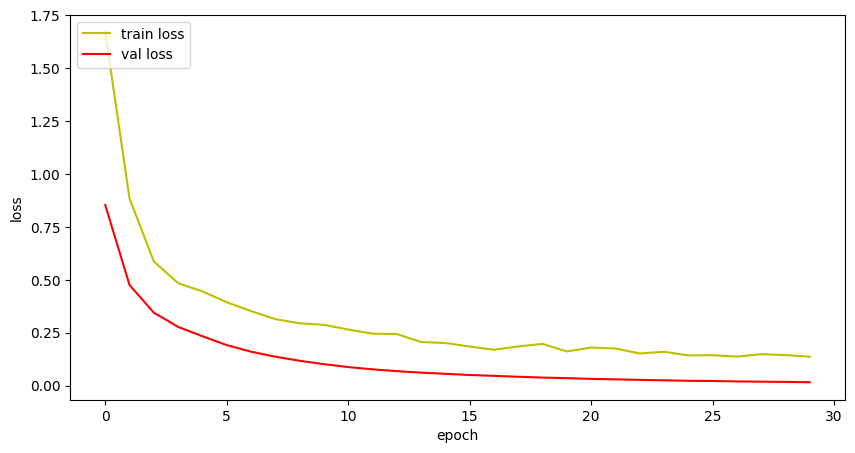

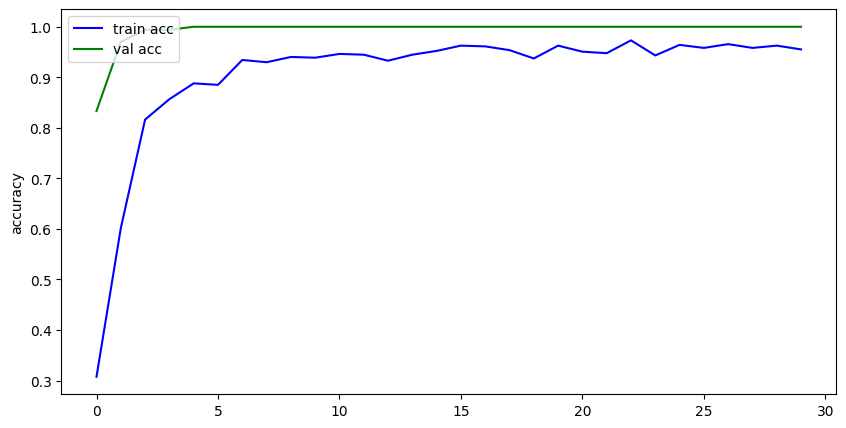

In [24]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(10, 5))

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

fig, acc_ax = plt.subplots(figsize=(10, 5))
acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()